In [111]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.types import IntegerType
import os
import pyspark.sql.functions as sql
import pandas as pd

In [112]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [113]:
spark = SparkSession\
  .builder \
  .appName("word_counter") \
  .getOrCreate()

In [114]:
filenames = os.listdir('data')
filenames

['NZ_traded_services_classification.csv',
 'machine-readable-business-employment-data-dec-2021-quarter.csv',
 'earthquake.csv',
 'country_indicators.csv',
 'european_leaders1.csv',
 'earthquake copy1.csv',
 'NZ_traded_services_classification1.csv',
 'tesla-stock-price.csv',
 'apartment_prices.csv',
 'european_leaders.csv']

In [115]:
data = []
amount_of_words_all_files = 0
countTokens = sql.udf(lambda w: len(w), IntegerType())

target_columns = {'NZ_traded_services_classification.csv': 'service_label', 
                  'earthquake copy1.csv': '1-50 Deaths', 
                  'machine-readable-business-employment-data-dec-2021-quarter.csv': 'Subject', 
                  'earthquake.csv': 'Unknown Number of Deaths', 
                  'country_indicators.csv': 'Indicator Name', 
                  'tesla-stock-price.csv': 'date', 
                  'apartment_prices.csv': 'District', 
                  'european_leaders.csv': 'country_name', 
                  'european_leaders1.csv': 'country_name', 
                  'NZ_traded_services_classification1.csv': 'service_label'}

In [116]:
for i in filenames:
    df = spark.read.format('csv').options(header='true', inferSchema='true').load(f'data/{i}')
    df = df.dropna()
    
    #Tokenizing text, while removing anything except words
    regextokenizer = RegexTokenizer(inputCol=target_columns[i], outputCol='words', gaps=False, pattern='\\b[a-zA-Z]+\\b')
    tokenized = regextokenizer.transform(df)
    
    #Removing stop words from the tokens
    remover = StopWordsRemover(inputCol='words', outputCol='cleaned')
    removed = remover.transform(tokenized)
    
    amount_of_words = [row['cleaned'] for row in removed.collect()]
    full_amount = 0
    for list in amount_of_words:
        full_amount+= len(list)
    
    print(f'In file {i} in the column {target_columns[i]} the total amount of words is {full_amount}\n')
    print(f'The top 10 words by amount are\n')
    removed = removed.withColumn('word', sql.explode(sql.col('cleaned'))).groupBy('word').count().sort('count', ascending=False)
    removed.show(10)

    amount_of_words_all_files +=full_amount

In file NZ_traded_services_classification.csv in the column service_label the total amount of words is 215

The top 10 words by amount are

+---------+-----+
|     word|count|
+---------+-----+
| services|   37|
|financial|    6|
|   travel|    6|
|  related|    6|
|        e|    5|
| computer|    5|
|        n|    5|
|transport|    5|
| personal|    5|
| business|    4|
+---------+-----+
only showing top 10 rows

In file machine-readable-business-employment-data-dec-2021-quarter.csv in the column Subject the total amount of words is 0

The top 10 words by amount are

+----+-----+
|word|count|
+----+-----+
+----+-----+

In file earthquake.csv in the column Unknown Number of Deaths the total amount of words is 8

The top 10 words by amount are

+---------+-----+
|     word|count|
+---------+-----+
|     port|    1|
|      new|    1|
|caledonia|    1|
|   noumea|    1|
|  vanuatu|    1|
|battagram|    1|
| pakistan|    1|
|     vila|    1|
+---------+-----+

In file country_indicators.cs

In [117]:
print(f'Amount of words in all files is {amount_of_words_all_files}')

Amount of words in all files is 133709


# Decided to select country_indicators.csv file


In [125]:
df = pd.read_csv(f'data/country_indicators.csv')
full_string = " ".join(df['Indicator Name'])

In [129]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

tokeniser = RegexpTokenizer("[A-Za-z]+")
tokens = tokeniser.tokenize(full_string)
print(f"First 10 tokens {tokens[:10]}")
print(f"Number of tokens {len(tokens)}")
uniq_num = len(set(tokens))
print(f"Number of unique tokens {uniq_num}")

First 10 tokens ['Agriculture', 'value', 'added', 'of', 'GDP', 'CO', 'emissions', 'metric', 'tons', 'per']
Number of tokens 227040
Number of unique tokens 55


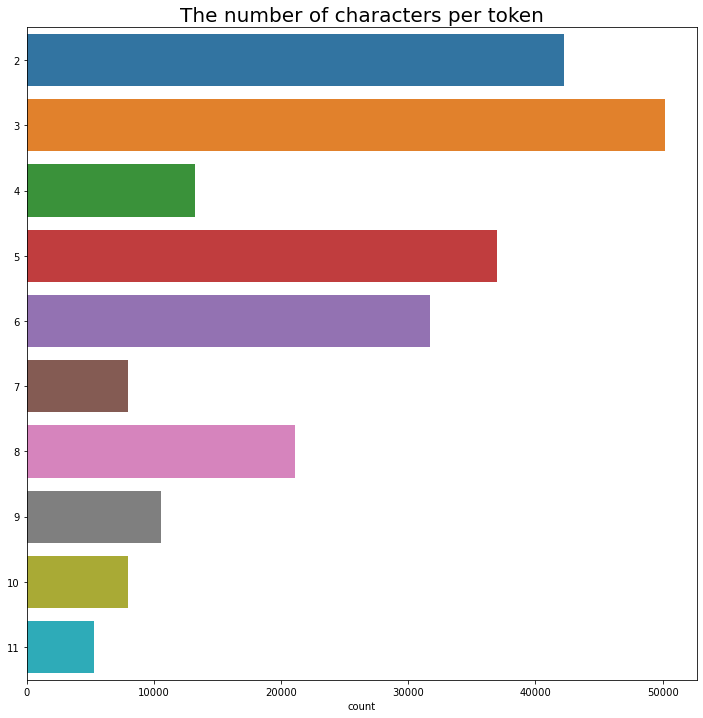

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

token_length = [len(t) for t in tokens]

plt.figure(figsize=(12, 12))
sns.countplot(y=token_length)
plt.title("The number of characters per token", size=20)
plt.show()

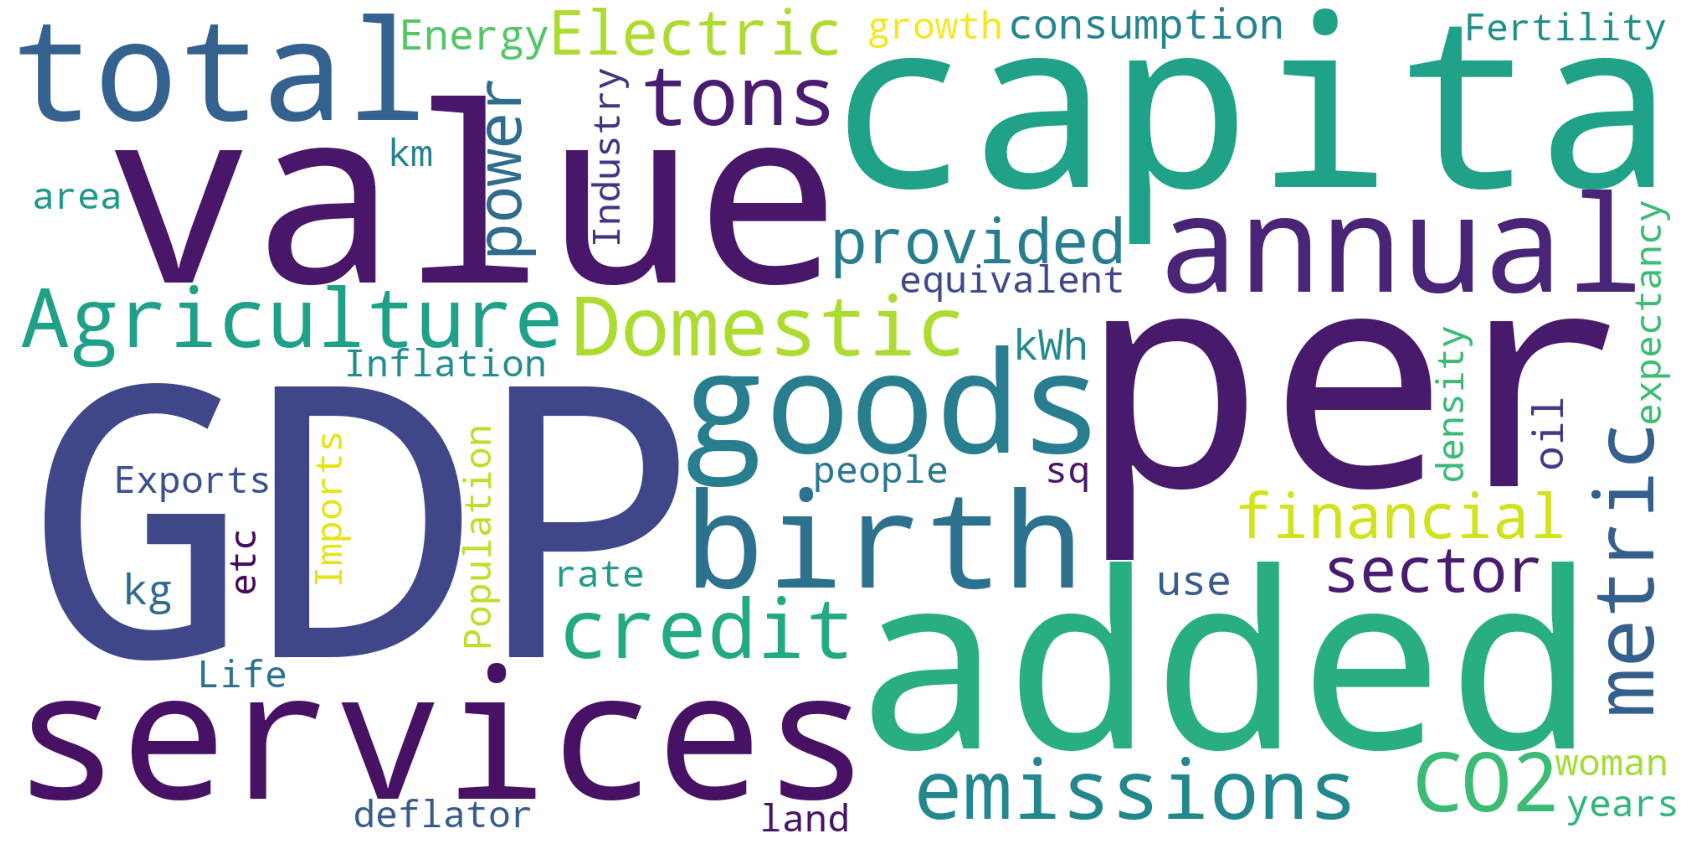

In [131]:
from wordcloud import WordCloud, STOPWORDS

data = df['Indicator Name'].to_json()
wordcloud = WordCloud(width = 2000, height = 1000, random_state=7, background_color='white', collocations=False, stopwords = STOPWORDS).generate(data)

plt.figure(figsize=(30, 20))
plt.imshow(wordcloud) 
plt.axis("off")

plt.show()
